### Big Data Stock Price Prediction using LSTM

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [27]:
tickers = ['AAPL', 'AMZN', 'PLTR', 'IBM', 'ORCL']

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

def add_indicators(df):
    df["SMA_50"] = df["Close"].rolling(window=50).mean()  # 50-day SMA
    df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()  # 50-day EMA

    # Relative Strength Index (RSI)
    delta = df["Close"].diff(1)
    gain = np.where(delta > 0, delta, 0).flatten()
    loss = np.where(delta < 0, -delta, 0).flatten()
    avg_gain = pd.Series(gain, index=df.index).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD (12-day EMA - 26-day EMA)
    df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()

    # Bollinger Bands (20-day)
    df["BB_Upper"] = df["Close"].rolling(window=20).mean() + (df["Close"].rolling(window=20).std() * 2)
    df["BB_Lower"] = df["Close"].rolling(window=20).mean() - (df["Close"].rolling(window=20).std() * 2)

    return df

X = []
y = []
t = True

for t in tickers:
    data_t = yf.download(t, start="2018-01-01", end=datetime.datetime.today().strftime('%Y-%m-%d'))

    data_t = add_indicators(data_t)
    data_t.dropna(inplace=True)

    features = ["Close", "SMA_50", "EMA_50", "RSI", "MACD", "BB_Upper", "BB_Lower"]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_t[features])

    seq_length = 60
    X_t, y_t = create_sequences(scaled_data, seq_length)

    if t:
        X = X_t
        y = y_t
        t = False
    else:
        X += X_t
        y += y_t

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

c:\Users\Simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.fit(X, y, epochs=50, batch_size=32, validation_data=(X, y), verbose=1)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0303 - val_loss: 0.0011
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0027 - val_loss: 9.3022e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0019 - val_loss: 6.0536e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0017 - val_loss: 9.4917e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017 - val_loss: 5.9872e-04
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0018 - val_loss: 5.6390e-04
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0016 - val_loss: 9.5474e-04
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0021 - val_loss: 7.4755e-04
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0014 - val_loss: 5.6460e-04
Epoch 12/50
53/53 ━━━━━━━━━━━━━

In [41]:
data = yf.download('GOOGL', start="2022-01-01", end=datetime.datetime.today().strftime('%Y-%m-%d'))

data = add_indicators(data) 
data.dropna(inplace=True)

features = ["Close", "SMA_50", "EMA_50", "RSI", "MACD", "BB_Upper", "BB_Lower"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

seq_length = 60
X_t, y_t = create_sequences(scaled_data, seq_length)

predictions = model.predict(X_t)
predictions = scaler.inverse_transform(np.hstack([predictions] + [np.zeros((predictions.shape[0], len(features) - 1))]))[:,0]

[*********************100%***********************]  1 of 1 completed

 7/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


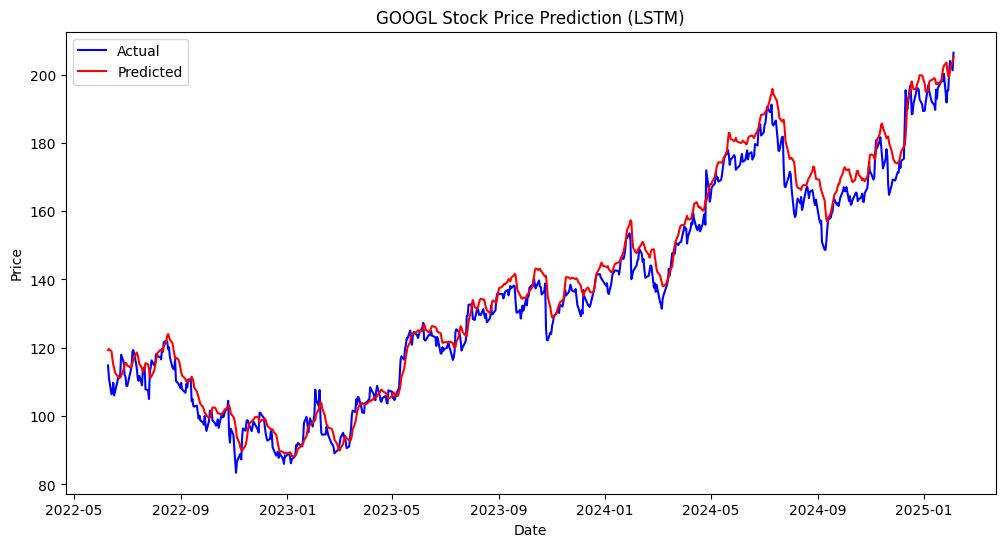

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(predictions):], data["Close"].values[-len(predictions):], label="Actual", color="blue")
plt.plot(data.index[-len(predictions):], predictions, label="Predicted", color="red")
plt.title("GOOGL Stock Price Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()



plt.show()